In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sphere_math

X0 = torch.load('data\\X0.pt')
V = torch.load('data\\V.pt')
pos = torch.load('data\\pos.pt')
X0.shape, V.shape, pos.shape

# def display_contents(path):
#     try:
#         items = os.listdir(path)
#         for item in items:
#             print(os.path.join(path, item))
#     except FileNotFoundError:
#         print(f"Error: Path not found: {path}")
#     except NotADirectoryError:
#         print(f"Error: Not a directory: {path}")
#     except PermissionError:
#         print(f"Error: Permission denied: {path}")

# # display_contents(path)
# print(os.getcwd())

C:\Users\Sathya\AppData\Local\Temp\ipykernel_12308\379769327.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0 = torch.load('data\\X0.pt')
C:\Users\Sathya\AppData\Local

(torch.Size([51408, 2]),
 torch.Size([51408, 100, 2]),
 torch.Size([51408, 100, 2]))

Comparing average and instantaneous velocities

In [2]:
pos_3d = sphere_math.immersion(pos)
jacobian_matrices = sphere_math.jacobian_matrix_batch(pos[:,0])
# jacobian_matrices.shape, V[:,0].unsqueeze(dim=-1).shape
V_3d = torch.bmm(jacobian_matrices, V[:,1].unsqueeze(dim=-1)).squeeze()
diff = pos_3d[:,1]-pos_3d[:,0]


In [8]:
i=2
(diff[:,i] - V_3d[:,i]).abs().median()

tensor(0.0021)

C:\Users\Sathya\AppData\Local\Temp\ipykernel_27232\682682945.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0 = torch.load('data\\X0.pt')
C:\Users\Sathya\AppData\Local

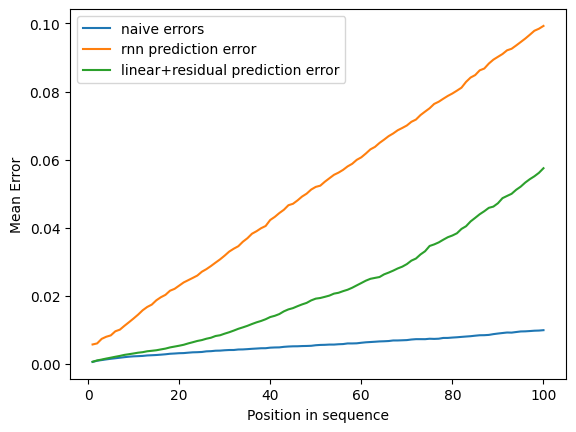

In [56]:
import torch
import matplotlib.pyplot as plt
import os
import sphere_math

X0 = torch.load('data\\X0.pt')
V = torch.load('data\\V.pt')
pos = torch.load('data\\pos.pt')


pos_pred = X0.unsqueeze(dim=1) + V.cumsum(dim=1)
errors_naive = (sphere_math.immersion(pos[800:1000]) - sphere_math.immersion(pos_pred[800:1000])).norm(dim=-1).mean(dim=0)
errors = (sphere_math.immersion(pos[800:1000]) - sphere_math.immersion(pos_pred_nn.detach())).norm(dim=-1).mean(dim=0)
errors_lpr = (sphere_math.immersion(pos[800:1000]) - sphere_math.immersion(pos_pred_lin_plus_residual.detach())).norm(dim=-1).mean(dim=0)

k=100
plt.plot(range(1,k+1), errors_naive[:k], label='naive errors')
plt.plot(range(1,k+1), errors[:k], label='rnn prediction error')
plt.plot(range(1,k+1), errors_lpr[:k], label='linear+residual prediction error')
plt.xlabel('Position in sequence')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

In [52]:
import models
from tqdm import tqdm
import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
import time
from sphere_math import immersion
def execute(model_name, hidden_dims, N_trajectories, X0=X0, V=V, pos=pos, num_epochs=1000, batch_size=1024, n_runs=1):
    def pickle_list(my_list, filename):
        """
        Pickles a list and saves it to a file.

        Args:
            my_list (list): The list to pickle.
            filename (str): The filename to save the pickled list to.
        """
        try:
            with open(filename, 'wb') as f:  # 'wb' for write binary
                pickle.dump(my_list, f)
            print(f"List pickled and saved to {filename}")
        except IOError as e:
            print(f"Error pickling list: {e}")

    if model_name == 'RNN':
        base_architecture = models.RNN
    elif model_name == 'LSTM':
        base_architecture = models.ConditionalLSTM
    elif model_name == 'GRU':
        base_architecture = models.ConditionalGRU
    else:
        raise ValueError(f'Invalid model name: {model_name}')
    
    class ResidualRNN(nn.Module):
        def __init__(self, input_size=2, hidden_size=32,  output_size=2):
            super(ResidualRNN, self).__init__()
            self.encoder = nn.Linear(input_size, hidden_size)
            self.rnnblock = nn.Linear(input_size+hidden_size, hidden_size)
            self.activation = nn.ReLU()
            self.decoder = nn.Linear(hidden_size, output_size)

        def forward(self, x_0, V):
            y0 = self.encoder(x_0)
            outputs = torch.zeros_like(V)
            for i in range(V.shape[1]):
                w = torch.cat([y0,V[:,i]], dim=-1)
                z = self.activation(self.rnnblock(w))
                y0 = y0 + z
                outputs[:,i] = self.decoder(y0)
            return outputs[:,-1]
    
    class Linear_plus_residual(nn.Module):
        def __init__(self, input_size=2, hidden_size=32,  output_size=2):
            super(Linear_plus_residual, self).__init__()
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.mlp = nn.Sequential(nn.Linear(2 * self.input_size, self.hidden_size), nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.output_size))

        def forward(self, x_0, V):
            y0 = x_0
            outputs = torch.zeros_like(V)
            for i in range(V.shape[1]):
                first_order = y0 + V[:,i]
                residual = self.mlp(torch.cat([y0, V[:,i]], dim=-1))
                y0 = first_order + residual
                outputs[:,i] = y0
            return outputs[:,-1]

    # X0, V, pos = torch.load(f'{path}\data\X0.pt').to(device)[:N_trajectories], torch.load(f'{path}\data\V.pt').to(device)[:N_trajectories], torch.load(f'{path}\data\pos.pt').to(device)[:N_trajectories]
    X0, V, pos = X0[:N_trajectories], V[:N_trajectories], pos[:N_trajectories]
    # RNN_models = [[base_architecture(hidden_size=d)]*n_runs for d in hidden_dims]
    # RNN_models = [[ResidualRNN(hidden_size=d)]*n_runs for d in hidden_dims]
    RNN_models = [[Linear_plus_residual(hidden_size=d)]*n_runs for d in hidden_dims]

    N = X0.shape[0]
    n = V.shape[1]
    # Data Preparation and Train-Test Splitting
    train_test_split = 0.8
    X0_train = X0[:int(train_test_split*N)]
    X0_test = X0[int(train_test_split*N):]
    V_train = V[:int(train_test_split*N)]
    V_test = V[int(train_test_split*N):]
    pos_train = pos[:int(train_test_split*N)]
    pos_test = pos[int(train_test_split*N):]



    def train(net, X0, V, pos, seq_length, indices_to_aggregate=[], lr=0.01, batch_size = 1024, num_epochs = num_epochs):
        k = seq_length
        # Define optimizer and scheduler
        optimizer = optim.Adam(net.parameters(), lr = lr)  # Example optimizer
        # Load your dataset
        train_loader = DataLoader(TensorDataset(X0, V, pos), batch_size=batch_size, shuffle=True)

        # Training loop
        num_epochs = num_epochs
        run_time = time.time()
        if len(indices_to_aggregate)>0:
            L = indices_to_aggregate
        else:
            L = range(1, k+1)
        # print(f"Training by aggregating on indices {L}")
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0

            for minibatch in train_loader:

                # Forward pass
                X = minibatch[0].to(device)
                V = minibatch[1].to(device)
                Y = minibatch[2].to(device)
                loss = 0

                for i in L:
                    Yhat = net(X,V[:,:i]).squeeze()
                    criterion = nn.MSELoss()
                    loss += criterion(immersion(Y[:,i-1]), immersion(Yhat))


                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # if epoch%100==0:
            #   print(f"Epoch = {epoch+1}, Loss = {running_loss/len(train_loader) :.4e}")
        runtime = time.time()-run_time  
        # print(f"Training time = {runtime}")
        return runtime


    # Training all models and computing predictions
    runtimes = []
    for dim, model_list in tqdm(zip(hidden_dims, RNN_models)):
        times = []
        for run, model in tqdm(enumerate(model_list)):
            t = train(model, X0=X0_train, V=V_train, pos=pos_train, seq_length=10, indices_to_aggregate=[], lr=0.01, batch_size = batch_size, num_epochs = num_epochs)
            times.append(t)
            # torch.save(model.state_dict(), f'{path}\model_weights\{model_name}\hidden_dim_{dim}_{run}.pth')
            model.eval()
            with torch.no_grad():
                pos_pred = torch.zeros_like(pos_test)
                for i in range(n):
                    pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()
            # torch.save(pos_pred, f'results\{base_name}\hidden_dim_{dim}_{run}.pt')
        # pickle_list(times, f'{path}\\runtimes\\runtimes_{model_name}_dim_{dim}.pkl')
    return pos_pred

# pos_pred_nn = execute(model_name='RNN', hidden_dims=[32], N_trajectories=1000, batch_size=512)
pos_pred_lin_plus_residual = execute(model_name='RNN', hidden_dims=[32], N_trajectories=1000, batch_size=512)

0it [00:00, ?it/s]























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [5]:
import pickle
def unpickle_list(filename):
    """
    Unpickles a list from a file.

    Args:
        filename (str): The filename to load the pickled list from.

    Returns:
        list or None: The unpickled list, or None if an error occurred.
    """
    try:
        with open(filename, 'rb') as f:  # 'rb' for read binary
            loaded_list = pickle.load(f)
        print(f"List unpickled from {filename}")
        return loaded_list
    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return None
    except (IOError, pickle.UnpicklingError) as e: #Handles more possible errors
        print(f"Error unpickling list: {e}")
        return None
    

unpickle_list('runtimes_dim_8.pkl')

List unpickled from runtimes_dim_8.pkl


[0.14872288703918457,
 0.09399938583374023,
 0.09020471572875977,
 0.08251452445983887,
 0.13127493858337402,
 0.09063410758972168,
 0.0845937728881836,
 0.10508394241333008,
 0.08269214630126953,
 0.09990859031677246]